# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 11: Clustering, Missingness, and Wrapup

**Harvard University**<br>
**Summer 2021**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Pavlos Protopapas, Chris Tanner, Eleni Kaxiras, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li> 
<li> Clustering </li> 
<li> Missingness and Imputation  </li> 
  

In [2]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator

## Learning Goals

This Jupyter notebook accompanies Lecture 11. By the end of this lecture, you should be more comfortable with:

- performing basic unsupervised clustering algorithms (k-means and hierarchical)
- using basic imputation models to handle missingness

## Part 0: Data 

For this section of the notebook we will be using 2 **unrelated** data sets:

1. The classic Fisher's Iris data set: [Wiki reference](https://en.wikipedia.org/wiki/Iris_flower_data_set)
2. `receiving_2020.csv`: NFL receiving statistics: [Source](https://www.pro-football-reference.com/years/2020/receiving.htm).  Note: receivers with fewer than 10 yards were removed.

Let's take a peak at them both:

In [3]:
# First, the common iris data set (from sklearn)
from sklearn import datasets
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)  
X.columns = iris.feature_names
y = iris.target
print(iris.target_names)
np.unique(y,return_counts=True)

['setosa' 'versicolor' 'virginica']


(array([0, 1, 2]), array([50, 50, 50]))

In [4]:
print(X.shape, y.shape)
X.head()

(150, 4) (150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
wr = pd.read_csv('../data/receiving_2020.csv')
print(wr.shape)
wr.head()

(455, 35)


,rank,player,id,team,age,pos,yards_before_catch,ybc_per_reception,yards_after_catch,before_catch_perc,...,td_per_reception,td,firstdowns_per_reception,first_downs,long,yards_per_target,receptions_per_game,yards_per_game,fumbles,fum_per_reception
0,1,Stefon Diggs*+,DiggSt00,BUF,27,WR,1071,8.4,464,0.697720,...,0.062992,8,0.574803,73,55,9.2,7.9,95.9,0,0.000000
1,5,Travis Kelce*+,KelcTr00,KAN,31,TE,829,7.9,587,0.585452,...,0.104762,11,0.752381,79,45,9.8,7.0,94.4,1,0.009524
2,3,DeAndre Hopkins*,HopkDe00,ARI,28,WR,873,7.6,534,0.620469,...,0.052174,6,0.652174,75,60,8.8,7.2,87.9,3,0.026087
3,15,Justin Jefferson *,JeffJu00,MIN,21,WR,947,10.8,453,0.676429,...,0.079545,7,0.659091,58,71,11.2,5.5,87.5,1,0.011364
4,2,Davante Adams*+,AdamDa01,GNB,28,WR,777,6.8,597,0.565502,...,0.156522,18,0.634783,73,56,9.2,8.2,98.1,1,0.008696


## Part 1a: *K*-Means Clustering

We first attempt *K*-Means clustering on the iris data set, which has a clear response variable (iris type).  Let's see if we can recover the three types through unsupervised clustering.  This is done using [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) in `sklearn.cluster`.

Let's start with $K=2$...unstandardized:

In [6]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=109).fit(X[['sepal length (cm)','sepal width (cm)']])

# sum of squares from the centroids
print("Sum of Squared Distances =", kmeans2.inertia_)

#predict for new (or current) observations
print("Predicted clusters for each observation =", kmeans2.predict(X[['sepal length (cm)','sepal width (cm)']]))
# print(kmeans2.labels_): predict will match this for the training set

#the centroids
print("Centroid vectors =", kmeans2.cluster_centers_)


Sum of Squared Distances = 58.204092789066756
Predicted clusters for each observation = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1]
Centroid vectors = [[6.61044776 2.96567164]
 [5.22409639 3.1313253 ]]


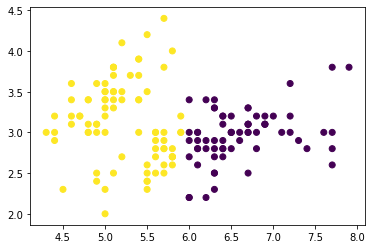

In [7]:
plt.scatter(X['sepal length (cm)'],X['sepal width (cm)'],c=kmeans2.labels_);

**Q1.1** Edit the code above to re-run the analysis with various different seeds.  Do the results change?

**Answer:** Yes the results change.  The classes sometimes flip, and if you get "unlucky", you may get a slightly different clustering (more likely to happen with more clusters or with more predictors than just 2). Recall: the initialization is random, and thus can lead to slightly different results (converging to a different local minimum).



**Q1.2** Edit the code above to re-run the analysis using the standardized predictors (the first two) and compare the results.

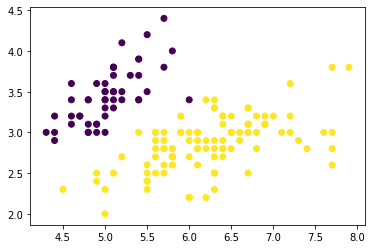

In [8]:
########
# your code here
########
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit(X[['sepal length (cm)','sepal width (cm)']]).transform(X[['sepal length (cm)','sepal width (cm)']])
kmeans2 = KMeans(n_clusters=2, random_state=109).fit(X_std)

plt.scatter(X['sepal length (cm)'],X['sepal width (cm)'],c=kmeans2.labels_);


**Answer:** This clustering seems to make more sense visually: here, the lower-right points seem to be one cluster, and should not be split across the two clusters (as was done originally).  Standardizing is typically a better choice.

**Q1.3** Re-run the analysis from above for $K=3$ and $K=4$.  Which appears to perform the best based on the scatterplots and based on the elbow method?

In [9]:
########
# edit and add to the code below
########

kmeans3 = KMeans(n_clusters=3, random_state=42).fit(X_std)
kmeans4 = KMeans(n_clusters=4, random_state=42).fit(X_std)



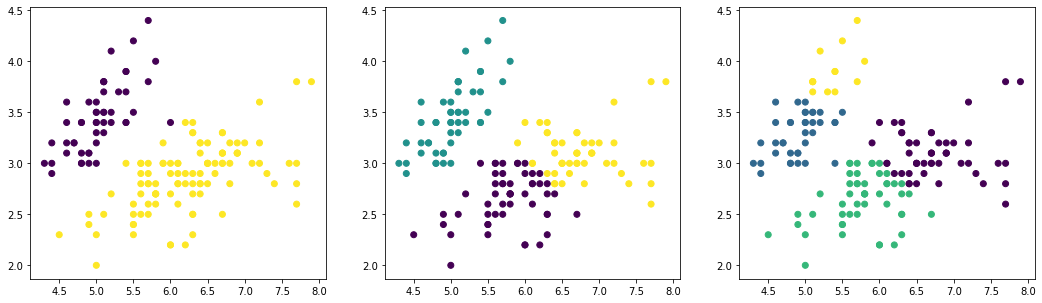

In [10]:
# plot the three scatterplots like the one from above
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))

ax1.scatter(X['sepal length (cm)'],X['sepal width (cm)'],c=kmeans2.labels_);
ax2.scatter(X['sepal length (cm)'],X['sepal width (cm)'],c=kmeans3.labels_);
ax3.scatter(X['sepal length (cm)'],X['sepal width (cm)'],c=kmeans4.labels_);

plt.show();

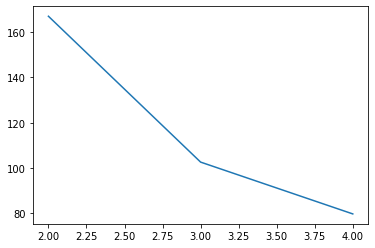

In [11]:
# plot (y = Sum of Squared Distances) vs. (x = K) and evaluate.

plt.plot([2,3,4],[kmeans2.inertia_,kmeans3.inertia_,kmeans4.inertia_]);



**Answer:** Eyeballing it from the scatterplots, I would actually suggest using $K=2$ as splitting either of those two clusters does not seem necessary, though I can see arguments for $K=3$. The elbow method suggests $K=3$ is likely a wise choice as there is a kink at that point in the plot (more $K$s should be considered to be certain of this choice).

**Q1.4** Compare the $K=3$ model with the actual 3 classes (`pd.crosstab` may be helpful).  How did we perform.

In [12]:
#######
# Your code here
#######
pd.crosstab(y,kmeans3.predict(X_std))

col_0,0,1,2
row_0,,,
0,1,49,0
1,35,0,15
2,16,0,34


**Answer:** Here we did pretty well to re-create the actual species (the rows represent `y` and the columns represent `y_hat`).  Species zero has 98% accuracy, while species 1 has 70% accuracy, and species 2 has 68% accuracy.  Note: when performing unsupervised clustering, the labels of the generated clusters/classes are swappable: the algorithm has no way to know which group should be 0 vs. 1 since there are no true labels involved.

---

**Q1.5** Perform a *K*-Means clustering analysis on the receiving data using the following variables:

`['age','before_after_ratio','depth_of_target','broken_tackles_per_reception','drop_perc', 'catch_perc','td_per_reception','firstdowns_per_reception','fum_per_reception']`.  

Consider using `Ks = np.arange(2,15,1)`.  Which $K$ would you select based on the elbow method?

Note: these variables were specifically chosen because they are not directly related to receiving ability...more a representation of play style.

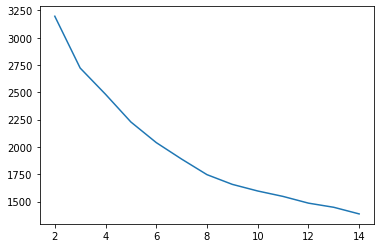

In [13]:
#######
# Your code here
#######
X = wr[['age','before_catch_perc','depth_of_target','broken_tackles_per_reception','drop_perc',
        'catch_perc','td_per_reception','firstdowns_per_reception','fum_per_reception']]
X_std =  pd.DataFrame(StandardScaler().fit_transform(X))

Ks = np.arange(2,15,1)
distances = []
for K in Ks:
    model = KMeans(n_clusters=K, random_state=109).fit(X_std)
    distances = np.append(distances, model.inertia_)

plt.plot(Ks,distances);



**Answer:** I would argue that there is an elbow/kink at $K=3$, but an argument for either $K=5$ or $K=8$ is reasonable.  But the simpler model is typically preferred for interpretations, $K=3$ is what we will use going forward.

**Q1.6** Investigate the top 3 players in each of the clusters.  Are there any general patterns you notice (especially in the variables like `yards`, `rank`, and `pos`)?

In [14]:
#######
# Your code here
#######

model = KMeans(n_clusters=3, random_state=109).fit(X_std)

cluster0 = wr[model.labels_==0]
cluster1 = wr[model.labels_==1]
cluster2 = wr[model.labels_==2]

print(cluster0.shape,cluster1.shape,cluster2.shape)


(295, 35) (159, 35) (1, 35)


In [15]:
cluster0.iloc[np.argsort(cluster0['rank'])][:3]

,rank,player,id,team,age,pos,yards_before_catch,ybc_per_reception,yards_after_catch,before_catch_perc,...,td_per_reception,td,firstdowns_per_reception,first_downs,long,yards_per_target,receptions_per_game,yards_per_game,fumbles,fum_per_reception
0,1,Stefon Diggs*+,DiggSt00,BUF,27,WR,1071,8.4,464,0.697720,...,0.062992,8,0.574803,73,55,9.2,7.9,95.9,0,0.000000
4,2,Davante Adams*+,AdamDa01,GNB,28,WR,777,6.8,597,0.565502,...,0.156522,18,0.634783,73,56,9.2,8.2,98.1,1,0.008696
2,3,DeAndre Hopkins*,HopkDe00,ARI,28,WR,873,7.6,534,0.620469,...,0.052174,6,0.652174,75,60,8.8,7.2,87.9,3,0.026087


In [16]:
cluster1.iloc[np.argsort(cluster1['rank'])][:3]

,rank,player,id,team,age,pos,yards_before_catch,ybc_per_reception,yards_after_catch,before_catch_perc,...,td_per_reception,td,firstdowns_per_reception,first_downs,long,yards_per_target,receptions_per_game,yards_per_game,fumbles,fum_per_reception
43,19,Alvin Kamara *,KamaAl00,NOR,25,rb,25,0.3,731,0.033069,...,0.060241,5,0.421687,35,52,7.1,5.5,50.4,1,0.012048
76,23,J.D. McKissic,McKiJ.00,WAS,27,rb,86,1.1,503,0.146010,...,0.025000,2,0.400000,32,29,5.4,5.0,36.8,3,0.037500
92,41,Nyheim Hines,HineNy00,IND,24,rb,12,0.2,470,0.024896,...,0.063492,4,0.380952,24,29,6.3,3.9,30.1,0,0.000000


In [17]:
cluster2

,rank,player,id,team,age,pos,yards_before_catch,ybc_per_reception,yards_after_catch,before_catch_perc,...,td_per_reception,td,firstdowns_per_reception,first_downs,long,yards_per_target,receptions_per_game,yards_per_game,fumbles,fum_per_reception
441,435,Josh Allen *,AlleJo02,BUF,24,QB,-5,-5.0,17,-0.416667,...,1.0,1,1.0,1,12,12.0,0.1,0.8,9,9.0


In [18]:
pd.crosstab(model.labels_,wr.pos)

pos,FB,QB,RB,TE,WR,fb,qb,rb,ss,te,wr
row_0,,,,,,,,,,,
0,2,1,0,22,53,0,1,2,0,54,97
1,1,0,21,7,0,7,0,49,1,4,9
2,0,1,0,0,0,0,0,0,0,0,0


In [19]:
pd.crosstab(model.labels_,wr['pos'].str.lower())

pos,fb,qb,rb,ss,te,wr
row_0,,,,,,
0,2,2,2,0,76,150
1,8,0,70,1,11,9
2,0,1,0,0,0,0


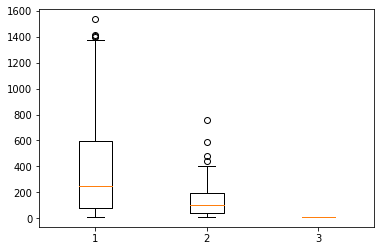

In [20]:
plt.boxplot([cluster0['yards'],cluster1['yards'],cluster2['yards']]);

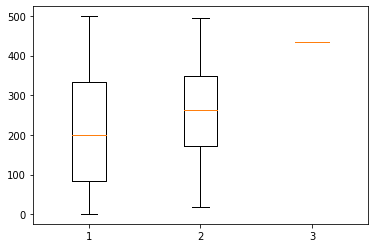

In [21]:
plt.boxplot([cluster0['rank'],cluster1['rank'],cluster2['rank']]);

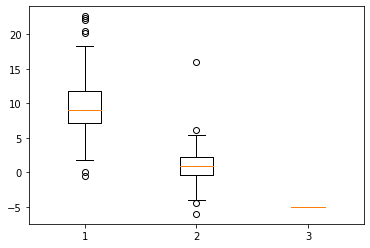

In [22]:
plt.boxplot([cluster0['depth_of_target'],cluster1['depth_of_target'],cluster2['depth_of_target']]);

**Answer:** This is not the easiest task (especially if you selected more clusters).  Note: it is less than ideal that cluster #2 has only a single observation in it :(

The exploratory analyses make the results of the clustering quite clear: we are clustering into positions (which is highly related to deth of target), in some sense.  Cluster 0 is composed mostly of WRs and TEs, cluster 1 is composed mostly of RBs and various other individuals, and cluster 2 is comprised of *lonely* Josh Allen: a QB that caught a single pass 5 yards behind the line of scrimmage, ran for 17 yards after that catch, and scored a TD on the play (a misdirection/trick play).  Here's a video of it: [YouTube](https://www.youtube.com/watch?v=ZeadfjfQY_U).

This illustrates the fact that cleaning your data is imortant.  Here, it would likely be a wise choice to limit this analysis to only players that have a minimal number of catches or targets (suggestion: limit it to those with 10 or more targets and/or throw away the QBs).  Then the results would likely be better and more interpretable...and likely to avoid having a cluster with a single observation.

Note: this is quite a messy data set: the positions are all over the place with case (aka, capitalization).  Using `wr['pos'].str.lower()` helped clean that up.

---

Side note: here's how you fit a Hierarchical Clustering:

In [23]:
# fitting a hierarchical clustering
hier_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_std)
print(hier_cluster.children_.shape)
print(hier_cluster.distances_.shape)



(454, 2)
(454,)


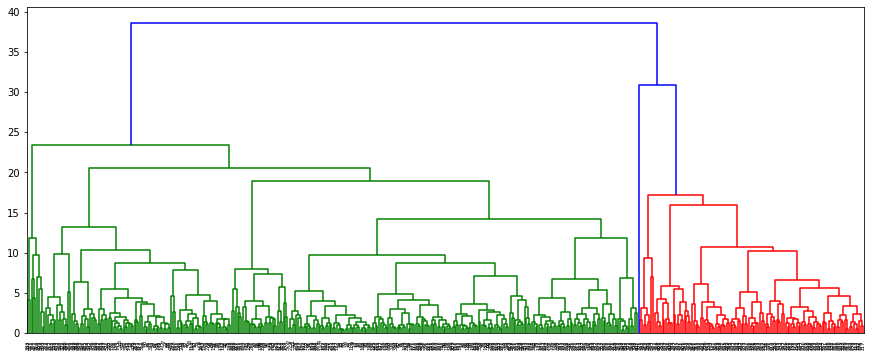

In [24]:

from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(15,6))    
plot_dendrogram(hier_cluster)

# Note: the plot_dendrogram come from here:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

This dendrogram agains illustrates the lonely Josh Allen if 3 clusters were chosen.  


Let's try a different dissimilarity metric: the (cosine similarity score)[https://en.wikipedia.org/wiki/Cosine_similarity], which is a more correlation-like metric between observations (scales the individual observations' measures).

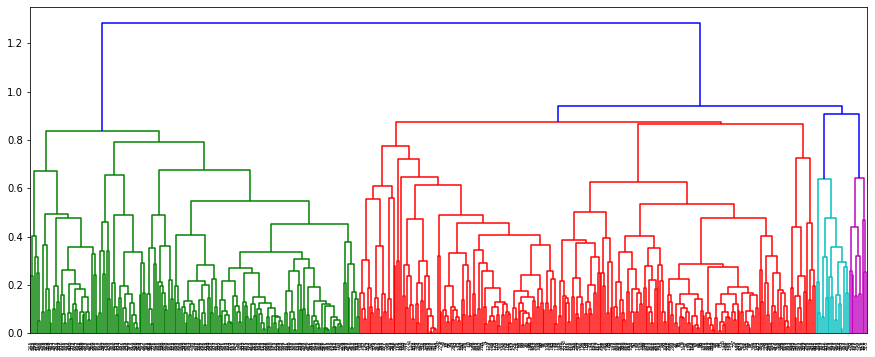

In [25]:
hier_cluster_cosine = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = 'average', affinity='cosine').fit(X_std)

plt.figure(figsize=(15,6)) 
plot_dendrogram(hier_cluster_cosine)

Now we start to see a more reasonable result, potentially (we've at least avoided the singleton of Josh Allen).  We can rerun the algorithm for a given number of clusters (let's choose 4 here for some variety...and the colors in the dendrogram at least suggest that as a reasonable choice):

In [26]:
hier4 = AgglomerativeClustering(n_clusters=4, linkage = 'average', affinity='cosine').fit(X_std)

pd.crosstab(hier4.labels_,wr['pos'].str.lower())

pos,fb,qb,rb,ss,te,wr
row_0,,,,,,
0,1,0,1,0,60,136
1,9,0,71,1,21,15
2,0,0,0,0,1,6
3,0,3,0,0,5,2


---

## Part 2: Dealing with Missingness


Here, we create data in which the true theoretical regression line is:
$$ Y = 3X_1 + 2X_2 + \varepsilon,\hspace{0.1in} \varepsilon \sim N(0,1)$$

Note: $\rho_{X1,X2} = 0.5$

We will be inserting missingness into `x1` in various ways, and analyzing the results.

In [27]:
import scipy

n = 500
np.random.seed(109)

x1 = np.random.normal(0,1,size=n)
x2 = 0.5*x1+np.random.normal(0,np.sqrt(0.75),size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])

y = 3*x1 - 2*x2 + np.random.normal(0,1,size=n)
y = pd.Series(y)


df = pd.DataFrame(data=np.transpose([x1,x2,y]),columns=["x1","x2","y"])

# Checking the correlation
scipy.stats.pearsonr(x1,x2) 

(0.5271942804503282, 4.1170313293023814e-37)

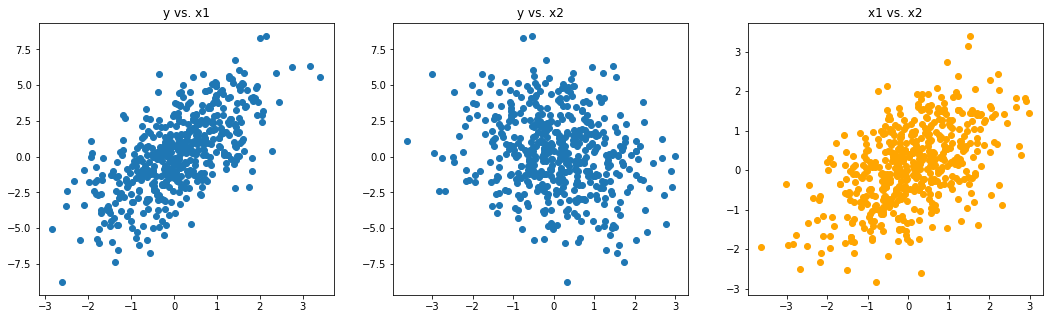

In [28]:
fig,(ax1,ax2,ax3) =  plt.subplots(1, 3, figsize = (18,5))
ax1.scatter(x1,y)
ax2.scatter(x2,y)
ax3.scatter(x2,x1,color="orange")
ax1.set_title("y vs. x1")
ax2.set_title("y vs. x2")
ax3.set_title("x1 vs. x2")
plt.show()

### Poke holes in $X_1$ in 3 different ways (all roughly 20% of data are removed): 

- MCAR: just take out a random sample of 20% of observations in $X_1$
- MAR: missingness in  $X_1$ depends on $X_2$, and thus can be recovered in some way
- MNAR: missingness in  $X_1$ depends on $X_1$, and thus can be recovered in some way


In [29]:
x1_mcar = x1.copy()
x1_mar = x1.copy()
x1_mnar = x1.copy()

#missing completely at random
miss_mcar = np.random.choice(n,int(0.2*n),replace=False)
x1_mcar[miss_mcar] = np.nan

#missing at random: one way to do it
miss_mar = np.random.binomial(1,0.05+0.85*(x2>(x2.mean()+x2.std())),n)
x1_mar[miss_mar==1] = np.nan

#missing not at random: one way to do it
miss_mnar = np.random.binomial(1,0.05+0.85*(y>(y.mean()+y.std())),n)
x1_mnar[miss_mnar==1] = np.nan

In [30]:
# Create the 3 datasets with missingness
df_mcar = df.copy()
df_mar = df.copy()
df_mnar = df.copy()

# plug in the appropriate x1 with missingness
df_mcar['x1'] = x1_mcar
df_mar['x1'] = x1_mar
df_mnar['x1'] = x1_mnar

In [31]:
# no missingness: on the full dataset
ols = LinearRegression().fit(df[['x1','x2']],df['y'])
print(ols.intercept_,ols.coef_)

0.10204379528391672 [ 2.92281015 -1.93658251]


In [32]:
# Fit the linear regression blindly on the dataset with MCAR missingness, see what happens
LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Q2.1** Why aren't the estimates exactly $\hat{\beta}_1 = 3$ and $\hat{\beta}_2 = -2$ from the complete data set?  How does sklearn handle missingness?  What would be a first naive approach to handling missingness?

**Answer:** There is random sampling of data from the true population line ($n=500$) and there is random/stochastic noise, so the estimates will vary based on what sample of data is actually taken.

`sklearn` hates missingness: it won't even run the models!  The naive approach is to just drop the observations (rows) with the missingness.  One could drop the variable(s) (columns) instead, but that does not make sense here since we care about estimating all the $\beta$ coefficients.

### What happens when you just drop rows?

In [33]:
# no missingness for comparison sake
ols = LinearRegression().fit(X,y)
print(ols.intercept_,ols.coef_)

0.10204379528391672 [ 2.92281015 -1.93658251]


In [34]:
# MCAR: drop the rows that have any missingness
ols_mcar = LinearRegression().fit(df_mcar.dropna()[['x1','x2']],df_mcar.dropna()['y'])
print(ols_mcar.intercept_,ols_mcar.coef_)

0.11920998640429431 [ 2.93863687 -1.95022496]


In [35]:
### edTest(test_mar) ###

# MAR: drop the rows that have any missingness
ols_mar = LinearRegression().fit(df_mar.dropna()[['x1','x2']],df_mar.dropna()['y'])
print(ols_mcar.intercept_,ols_mar.coef_)

0.11920998640429431 [ 2.95841887 -1.91054504]


In [36]:
# MNAR: drop the rows that have any missingness
X_mnar_raw = X.copy()
X_mnar_raw['x1'] = x1_mnar
X_mnar = X.iloc[miss_mnar==0]
y_mnar = y[miss_mnar==0]

ols_mnar = LinearRegression().fit(X_mnar,y_mnar)
print(ols_mnar.intercept_,ols_mnar.coef_)

0.0006294788367179338 [ 2.77437893 -1.83485388]


**Q2.2** How do the estimates compare when just dropping rows?  Are they able to recover the values of $\beta_1$ that they should?  In which form of missingness is the result the worst?

**Answer:** The result of dropping rows depends on the missingness: only the sample size is affected under MCAR (thus our estimates will have a little more uncertainty); under MAR, the estimates are a little biased (here, $\hat{\beta}_2$ is actually worse than $\hat{\beta}_1$); and under MNAR, are estimates are pushed quite far away from reality (both coefficients are worse off than under MNAR or MCAR).

## Let's Start Imputing

In [37]:
X_mcar = df_mcar[['x1','x2']]
X_mar = df_mar[['x1','x2']]
X_mnar = df_mnar[['x1','x2']]

In [38]:
#Make back-=up copies for later since we'll have lots of imputation approaches.
X_mcar_raw = X_mcar.copy()
X_mar_raw = X_mar.copy()
X_mnar_raw = X_mnar.copy()

### Mean Imputation:

Perform mean imputation using the `fillna`, `dropna`, and `mean` functions.

In [39]:
X_mcar = X_mcar_raw.copy()
X_mcar['x1'] = X_mcar['x1'].fillna(X_mcar['x1'].dropna().mean())

ols_mcar_mean = LinearRegression().fit(X_mcar,y)
print(ols_mcar_mean.intercept_,ols_mcar_mean.coef_)

0.07741706175496277 [ 2.76479882 -1.64782188]


In [40]:
### edTest(test_mar_mean) ###

X_mar = X_mar_raw.copy()


X_mar['x1'] = X_mar['x1'].fillna(X_mar['x1'].dropna().mean())

ols_mar_mean = LinearRegression().fit(X_mar,y)
print(ols_mar_mean.intercept_,ols_mar_mean.coef_)

0.4190134064121406 [ 2.66029655 -1.22639957]


In [41]:
X_mnar = X_mnar_raw.copy()
X_mnar['x1'] = X_mnar['x1'].fillna(X_mnar['x1'].dropna().mean())

ols_mnar_mean = LinearRegression().fit(X_mnar,y)
print(ols_mnar_mean.intercept_,ols_mnar_mean.coef_)

0.54125703762347 [ 2.65222288 -1.66674473]


**Q2.3** How do the estimates compare when performing mean imputation vs. just dropping rows?  Have things gotten better or worse (for what types of missingness)?

**Answer:** The result of mean imputation is worse across the board here than dropping rows.  Surprisingly, the estimates are most affected under MAR (though that is not necessarily always the case).  If inference about your $\beta$s is the goal, then mean imputation is a very bad choice.

### Linear Regression Imputation 

This is difficult to keep straight.  There are two models here: 

1. an imputation model based on OLS concerning just the predictors (to predict $X_1$ from $X_2$) and 
2. the model we really care about to predict $Y$ from the 'improved' $X_1$ (now with imputed values) and $X_2$.

In [42]:
X_mcar = X_mcar_raw.copy()

# fit the imputation model
ols_imputer_mcar = LinearRegression().fit(X_mcar.dropna()[['x2']],X_mcar.dropna()['x1'])

# perform some imputations
yhat_impute = pd.Series(ols_imputer_mcar.predict(X_mcar[['x2']]))
X_mcar['x1'] = X_mcar['x1'].fillna(yhat_impute)

# fit the model we care about
ols_mcar_ols = LinearRegression().fit(X_mcar,y)
print(ols_mcar_ols.intercept_,ols_mcar_ols.coef_)

0.11220418095753587 [ 2.93863687 -2.00159509]


In [43]:
X_mar = X_mar_raw.copy()
ols_imputer_mar = LinearRegression().fit(X_mar.dropna()[['x2']],X_mar.dropna()['x1'])

yhat_impute = pd.Series(ols_imputer_mar.predict(X_mar[['x2']]))
X_mar['x1'] = X_mar['x1'].fillna(yhat_impute)

ols_mar_ols = LinearRegression().fit(X_mar,y)
print(ols_mar_ols.intercept_,ols_mar_ols.coef_)

0.06872418874114894 [ 2.95841887 -1.96118355]


In [44]:

X_mnar = X_mnar_raw.copy()
ols_imputer_mnar = LinearRegression().fit(X_mnar.dropna()[['x2']],X_mnar.dropna()['x1'])

yhat_impute = pd.Series(ols_imputer_mnar.predict(X_mnar[['x2']]))
X_mnar['x1'] = X_mnar['x1'].fillna(yhat_impute)

ols_mnar_ols = LinearRegression().fit(X_mnar,y)
print(ols_mnar_ols.intercept_,ols_mnar_ols.coef_)

0.6535573132179666 [ 2.77437893 -1.95978805]


**Q2.4**: How do the estimates compare when performing model-based imputation vs. mean imputation?  Have things gotten better or worse (for what types of missingness)?

**Answer:** Now the results are starting to looks a little better.  As expected, the estimates under MCAR is similar to dropping rows.  MAR appear to be right on track, and MNAR has improved from either method above (though $\hat{\beta}_1$ is still off a bit.  This is the most reasonable choice considered so far if removing bias of your $\beta$ estimates is the only goal.

### $k$-NN Imputation ($k$=1)

In [45]:
X_mcar = X_mcar_raw.copy()
X_mcar = KNNImputer(n_neighbors=1).fit_transform(X_mcar)

ols_mcar_knn = LinearRegression().fit(X_mcar,y)
print(ols_mcar_knn.intercept_,ols_mcar_knn.coef_)

0.1606408504046106 [ 2.40810773 -1.74530406]


In [46]:
X_mar = X_mar_raw.copy()
X_mar = KNNImputer(n_neighbors=1).fit_transform(X_mar)

ols_mar_knn = LinearRegression().fit(X_mar,y)
print(ols_mar_knn.intercept_,ols_mar_knn.coef_)

0.3473357109024488 [ 2.5527624  -1.37981145]


In [47]:
X_mnar = X_mnar_raw.copy()
X_mnar = KNNImputer(n_neighbors=1).fit_transform(X_mnar)

ols_mnar_knn = LinearRegression().fit(X_mnar,y)
print(ols_mnar_knn.intercept_,ols_mnar_knn.coef_)

0.5974467868950186 [ 2.36797864 -1.79954878]


**Q2.5**: Which of the 4 methods for handling missingness worked best?  Which worked the worst?  Were the estimates improved or worsened in each of the 3 types of missingness?

**Answer:** $k$-NN with $k=1$ does not improve the primary model's estimated $\beta$ coefficients. As mentioned above, using a linear regression type imputer is the only one considered that improved the results.  Note: $k$-NN with $k=1$ is an overfit model, so randomly selected a single observation from the neighborhood with $k$ properly tuned would be a better approach (try $k=20$).

**Q2.6**: This exercise focused on 'inference' (considering just the estimates of coefficients, not the uncertainty of these estimates, which would be even worse).  What are the ramifications on prediction?  Is the situation more or less concerning?  

**Answer:** Prediction is less concerning, especially in the presence of collinearity where the other predictors could make up for a variable's missigness.  So in this situation, dropping a predictor is reasonable if the missingness is too much.  Using a binary indicator of missingness in the model can help as well.

---